# FREDDY FERNANDES
freddy.fernandes@studio.unibo.it

## Task 2: Russet Detection

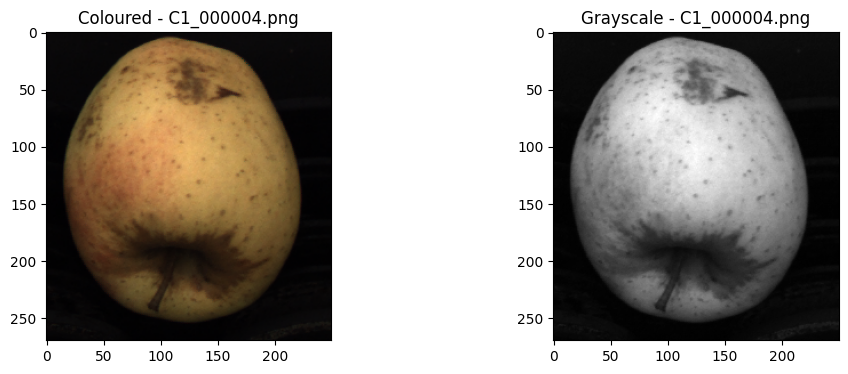

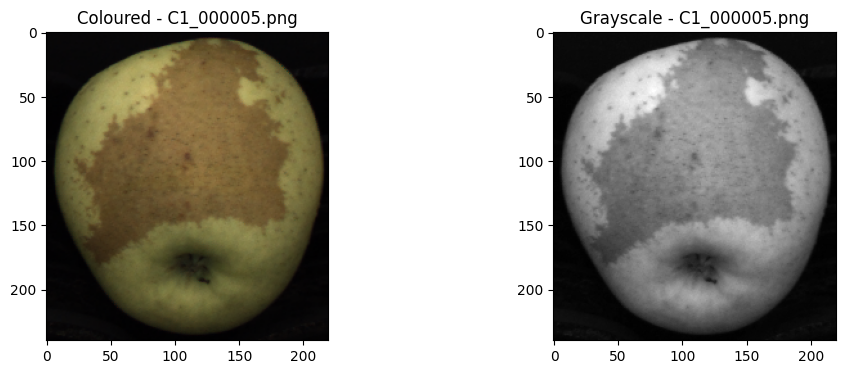

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# List of image filenames
image_list = ["C1_000004.png", "C1_000005.png"]

# Initialize lists to store RGB and grayscale images
images = []
gray_images = []

# Load, convert to grayscale, and smooth the images
for i in image_list:
    # Load the image in BGR format
    image = cv2.imread(f"second task/{i}")
    images.append(image)
    image1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert BGR to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_image)

    # Display the original image and grayscale
    plt.figure(figsize=(12, 4))
    # Plot original RGB image
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title(f"Coloured - {i}")

    # Plot grayscale image
    plt.subplot(1, 2, 2)
    plt.imshow(gray_image, cmap='gray')
    plt.title(f"Grayscale - {i}")
    plt.show()


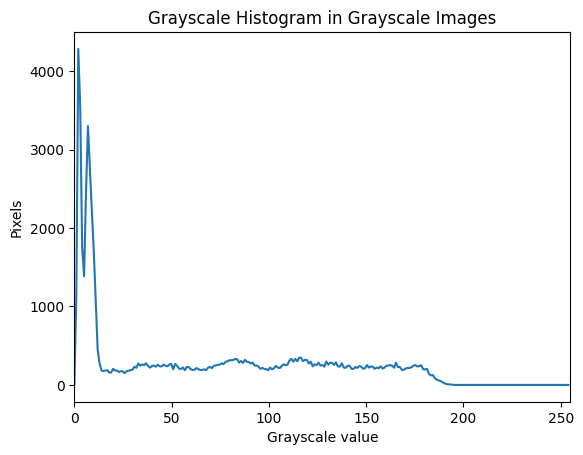

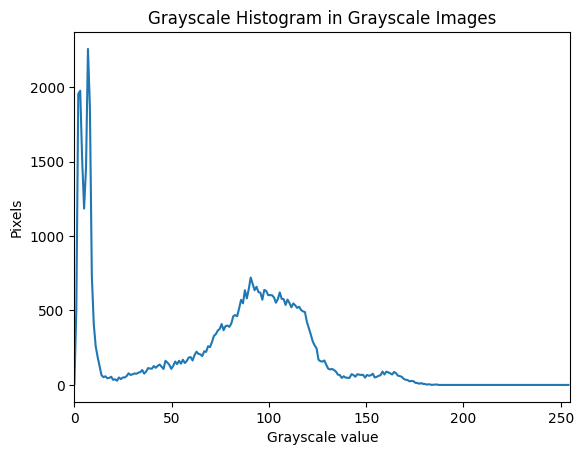

In [2]:
def plot_histogram_for_thresholding(image):
    # Calculating the histogram of the grayscale image
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 255))

    # Plotting the histogram
    plt.figure()
    plt.title("Grayscale Histogram in Grayscale Images")
    plt.xlabel("Grayscale value")
    plt.ylabel("Pixels")
    plt.xlim([0, 255])  # Setting the xlim to [0, 255]
    plt.plot(bin_edges[0:-1], histogram)  #Plotting the histogram
    plt.show()

for i in gray_images:
    plot_histogram_for_thresholding(i)

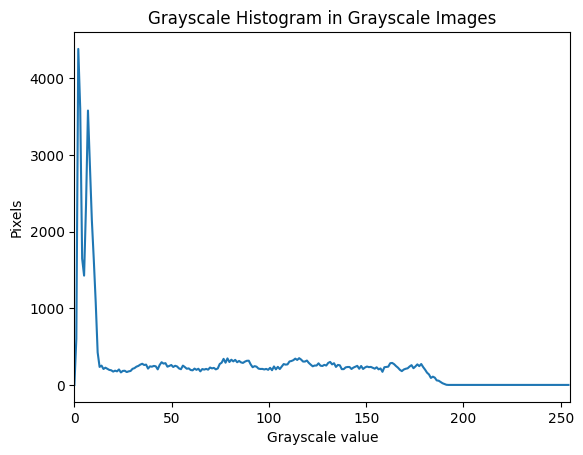

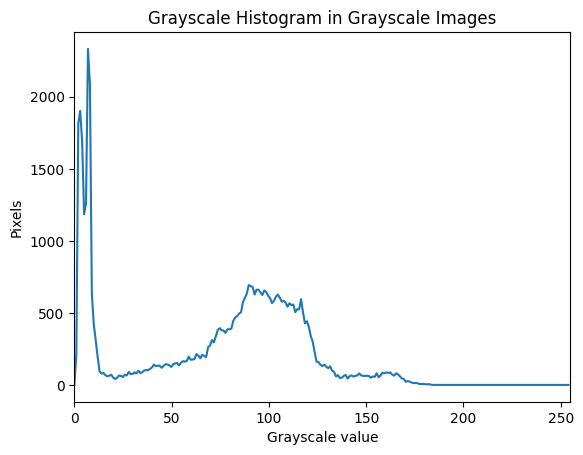

In [3]:
#Applying smoothing 
smooth_images = []
for i in gray_images:
    smooth= cv2.GaussianBlur(i, (5,5), 0)
    smooth_images.append(smooth)

for i in smooth_images:
    plot_histogram_for_thresholding(i)

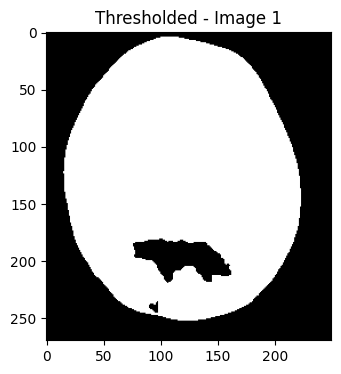

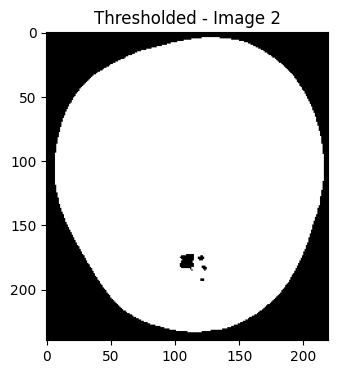

In [4]:
masks=[]

def threshold_and_plot(images):
    # Iterate over each image and apply thresholding
    for i, smooth_image in enumerate(images):
        _, mask = cv2.threshold(smooth_image, 30, 1, cv2.THRESH_BINARY)
        masks.append(mask)
        # Plot the thresholded image
        plt.figure(figsize=(8, 4))
        plt.imshow(mask, 'gray', vmin=0, vmax=1)
        plt.title(f"Thresholded - Image {i+1}")
        plt.show()

# Example usage
threshold_and_plot(smooth_images)


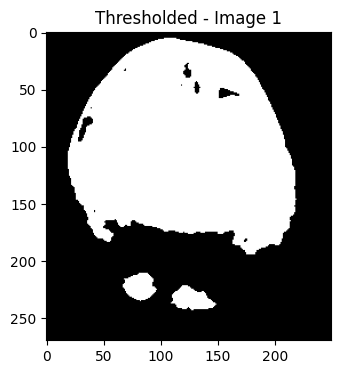

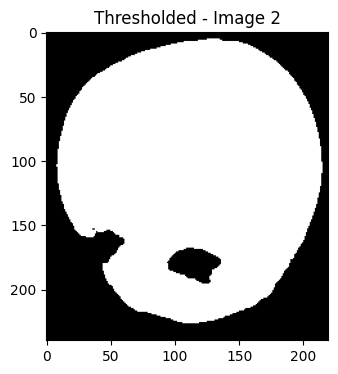

In [5]:
def otsu_threshold_and_plot(images):
    # Iterate over each image and apply thresholding
    for i, smooth_image in enumerate(images):
        _, mask = cv2.threshold(smooth_image ,0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # Plot the thresholded image
        plt.figure(figsize=(8, 4))
        plt.imshow(mask, 'gray', vmin=0, vmax=1)
        plt.title(f"Thresholded - Image {i+1}")
        plt.show()

# Example usage
otsu_threshold_and_plot(smooth_images)

Weird pattern being marked which isnt so accurate. Also the edges are being cropped

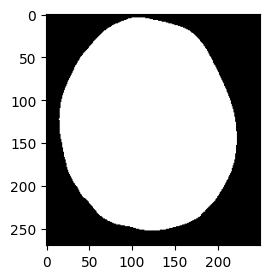

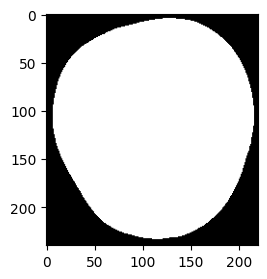

In [19]:
#Making a usable mask for later color spaces part
flood_masks= []
for mask in masks:
    flood_fill_mask = mask + 1 
    h, w = flood_fill_mask.shape
    mask_for_floodfill = np.zeros((h + 2, w + 2), np.uint8)
    # - The starting point for the fill is (0,0)
    # - The value '0' is filled in the areas connected to (0,0) and similar to it in the mask
    cv2.floodFill(flood_fill_mask, mask_for_floodfill, (0,0), 0)
    #Filling holes
    flood_fill_mask[flood_fill_mask == 2] = 1
    #Append the modified mask to the list
    flood_masks.append(flood_fill_mask)

    # Display the flood-filled mask:
    plt.figure(figsize=(3,3))
    plt.imshow(flood_fill_mask, cmap='gray')
    plt.show()


In [7]:
# Define new color spaces
colours = [
    (cv2.COLOR_BGR2RGB, "RGB"),
    (cv2.COLOR_BGR2HSV, "HSV"),
    (cv2.COLOR_BGR2HLS, "HLS"),
    (cv2.COLOR_BGR2Luv, "LUV")
]

# Initialize list  to store colored images for each image
different_images = [[] for _ in range(len(image_list))]

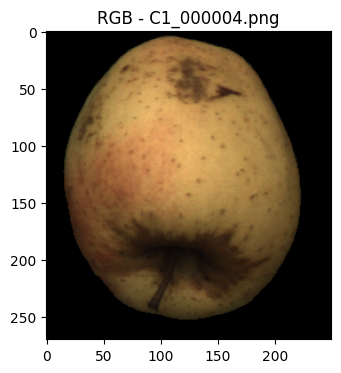

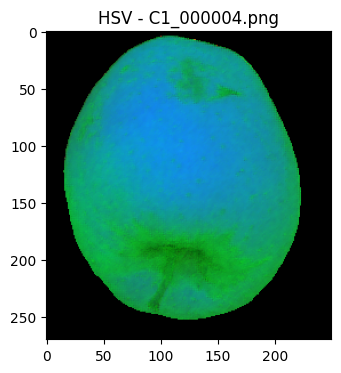

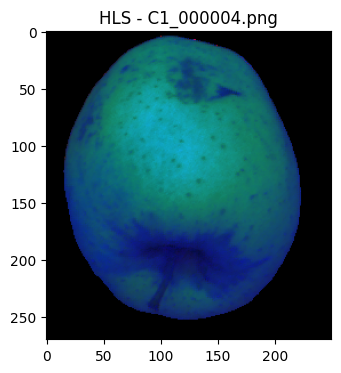

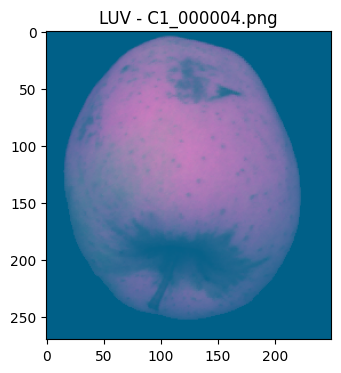

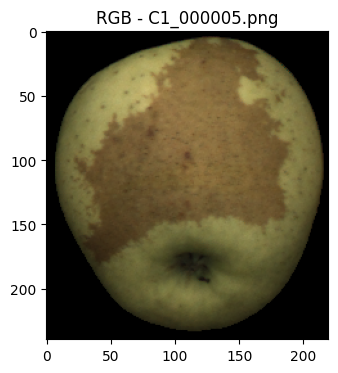

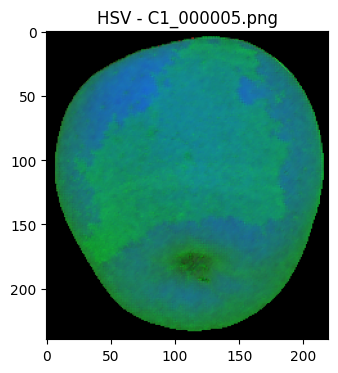

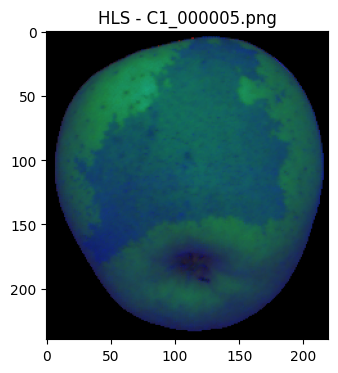

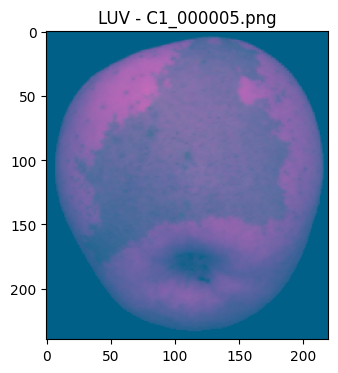

In [8]:
# Loop through each filename
for i, filename in enumerate(image_list):
    # Loop through each color space
    for cs, cs_name in colours:
        # Apply mask to each channel separately
        for channel in range(images[i].shape[2]):
            images[i][:, :, channel] *= flood_masks[i]
        # Convert image to the current color space
        converted = cv2.cvtColor(images[i], cs)
        # Append the converted image to the list
        different_images[i].append(converted)

        # Plot the converted image
        plt.figure(figsize=(8, 4))
        plt.imshow(converted)
        plt.title(f"{cs_name} - {filename}")
        plt.show()


In [14]:
def draw_roi(image, start, end):
    roi_image = cv2.rectangle(image.copy(), start, end, (255, 0, 0), 2)
    roi_mean = np.mean(image[start[1]:end[1], start[0]:end[0]], axis=(0, 1))
    return roi_image, roi_mean

start = (100, 100)  # (x, y) coordinates of the top-left corner of the ROI
end = (125, 125)  # (x, y) coordinates of the bottom-right corner of the ROI

for cs, img in zip(colours, different_images[1]):
    _, roi_mean = draw_roi(img, start, end)
    print(cs[1], roi_mean)


RGB [128.4512 102.3504  56.0352]
HSV [ 19.2272 143.92   128.4512]
HLS [ 19.2224  92.248  100.2784]
LUV [114.048  110.9824 167.504 ]


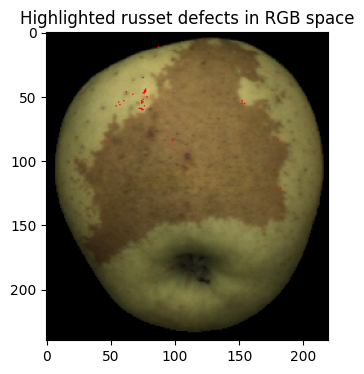

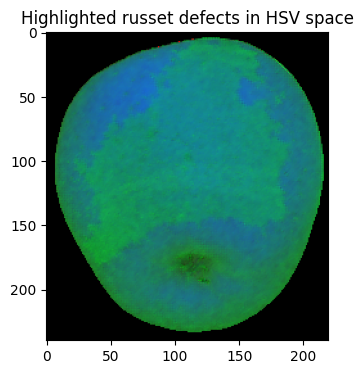

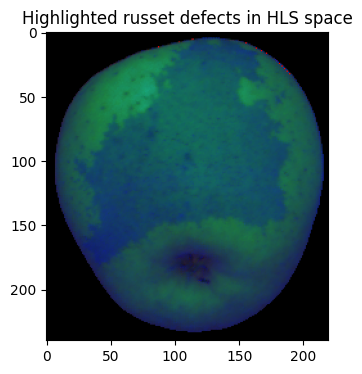

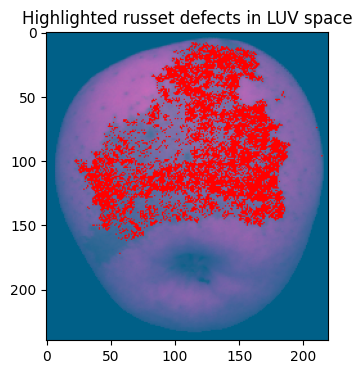

In [15]:
from scipy.spatial import distance

# Compute the inverse covariance matrix for each image
inv_cov_matrices = [np.linalg.inv(np.cov(img.reshape(-1, img.shape[-1]), rowvar=False)) for img in different_images[1]]

# Compute the Mahalanobis distance for each pixel in each image
mahalas = []
for img, inv_cov in zip(different_images[1], inv_cov_matrices):
    pixels_flat = img.reshape(-1, img.shape[-1])
    mahala = [distance.mahalanobis(pixel, roi_mean, inv_cov) for pixel in pixels_flat]
    mahalas.append(np.array(mahala).reshape(img.shape[:2]))

# Loop through each color space, image, and corresponding Mahalanobis distances
for cs, img, mahala in zip(colours, different_images[1], mahalas):
    # Create a copy of the image
    new_img = np.copy(img)
    
    # Normalize the Mahalanobis distances to the range [0, 255]
    mahala = 255 * (mahala - np.min(mahala)) / (np.max(mahala) - np.min(mahala))
    # Define the threshold
    threshold = 30    
    # Highlight the pixels with Mahalanobis distance less than the threshold
    new_img[mahala < threshold] = [255, 0, 0]

    # Display the image
    plt.figure(figsize=(8, 4))
    plt.imshow(new_img)
    plt.title(f"Highlighted russet defects in {cs[1]} space")
    plt.show()


In [16]:
def draw_roi(image, start, end):
    roi_image = cv2.rectangle(image.copy(), start, end, (255, 0, 0), 2)
    roi_mean = np.mean(image[start[1]:end[1], start[0]:end[0]], axis=(0, 1))
    return roi_image, roi_mean

# Example usage:
start = (150, 200)  # (x, y) coordinates of the top-left corner of the ROI
end = (170, 220)  # (x, y) coordinates of the bottom-right corner of the ROI

for cs, img in zip(colours, different_images[0]):
    _, roi_mean = draw_roi(img, start, end)
    print(cs[1], roi_mean)


RGB [44.085 28.075 15.24 ]
HSV [ 13.32  166.485  44.085]
HLS [ 13.3025  29.86   123.7325]
LUV [ 30.1375 102.4    143.32  ]


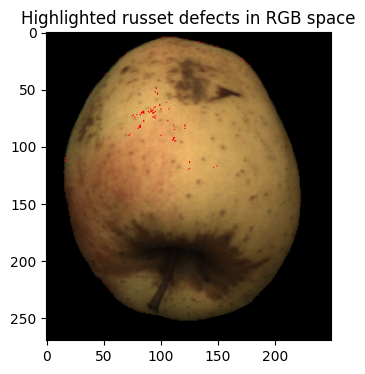

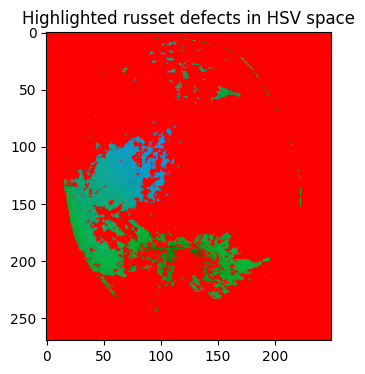

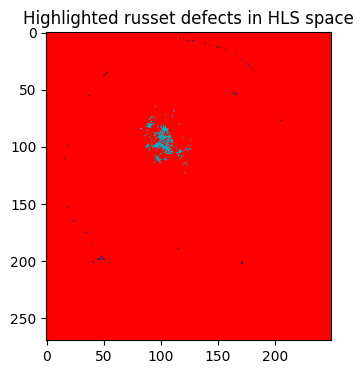

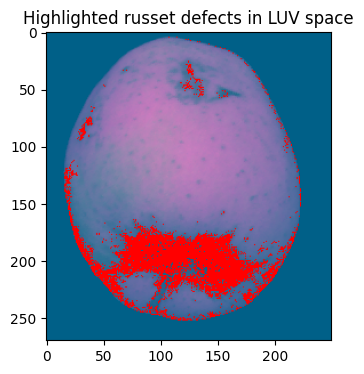

In [18]:
from scipy.spatial import distance

# Compute the inverse covariance matrix for each image
inv_cov_matrices = [np.linalg.inv(np.cov(img.reshape(-1, img.shape[-1]), rowvar=False)) for img in different_images[0]]

# Compute the Mahalanobis distance for each pixel in each image
mahalas = []
for img, inv_cov in zip(different_images[0], inv_cov_matrices):
    pixels_flat = img.reshape(-1, img.shape[-1])
    mahala = [distance.mahalanobis(pixel, roi_mean, inv_cov) for pixel in pixels_flat]
    mahalas.append(np.array(mahala).reshape(img.shape[:2]))

# Loop through each color space, image, and corresponding Mahalanobis distances
for cs, img, mahala in zip(colours, different_images[0], mahalas):
    # Create a copy of the image
    new_img = np.copy(img)

    # Normalize the Mahalanobis distances to the range [0, 255]
    normalized_mahala = 255 * (mahala - np.min(mahala)) / (np.max(mahala) - np.min(mahala))
    # Define the threshold
    threshold = 30
    # Highlight the pixels with Mahalanobis distance less than the threshold
    new_img[normalized_mahala < threshold] = [255, 0, 0]

    # Display the image
    plt.figure(figsize=(8, 4))
    plt.imshow(new_img)
    plt.title(f"Highlighted russet defects in {cs[1]} space")
    plt.show()
